In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('train_boston.csv')
df1.head()

,index,id,data,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zip_code,lat,lon,sqft_living15,sqft_lot15,price
0,6243,8850000509,9/23/14,2,1.50,1620,1444,2.0,0,0,...,1080,540,2007,0,98144,47.5892,-122.309,1660,1642,525000
1,8986,191100410,6/20/14,3,2.75,2470,10125,2.0,0,0,...,2470,0,1960,2012,98040,47.5651,-122.223,2290,10125,970500
2,9419,6632300040,4/25/15,2,1.00,1140,7435,1.0,0,0,...,1140,0,1952,1990,98125,47.7300,-122.310,1320,9385,327000
3,10155,7517500310,5/6/15,3,1.00,1460,6198,1.5,0,0,...,1460,0,1916,0,98107,47.6626,-122.361,2280,5160,775000
4,10436,7454000990,9/24/14,2,1.00,670,6720,1.0,0,0,...,670,0,1942,0,98126,47.5151,-122.372,710,6720,304950


# Data Cleaning

In [3]:
#I remove the spaces in the columns
df1.columns = [column.replace(' ','') for column in df1.columns]
df1.columns

Index(['index', 'id', 'data', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zip_code',
       'lat', 'lon', 'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [4]:
#dropping useless columns that won't contribute to the model. Lat and lon can be summarized with Zip_code
#And I'll use them in Tableau to map data
df1 = df1.drop(['index','lat','lon', 'id'], axis=1)

In [5]:
#I see there are no nulls
nulls = pd.DataFrame(df1.isna().sum()*100/len(df1), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

,percentage
data,0.0
bedrooms,0.0
sqft_lot15,0.0
sqft_living15,0.0
zip_code,0.0
yr_renovated,0.0
yr_built,0.0
sqft_basement,0.0
sqft_above,0.0
grade,0.0


In [6]:
#I want to check the types to see if they correspond with what they're supposed to be
df1.dtypes
#I see that some of them can be turned into objects to, later on, encode them
#For example bedrooms or bathrooms, that can be turned into different standards to define each house

data              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zip_code           int64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

In [7]:
#We saw on tableau that there's an overlap of some prices of houses that belong to an excellent grade with other of a low grade
df1.corr()['grade'].sort_values(ascending=False)

grade            1.000000
sqft_living      0.763637
sqft_above       0.756004
sqft_living15    0.716644
price            0.668464
bathrooms        0.666254
floors           0.454156
yr_built         0.445482
bedrooms         0.356455
view             0.257785
sqft_basement    0.174684
sqft_lot15       0.131490
sqft_lot         0.118996
waterfront       0.082233
yr_renovated     0.014433
condition       -0.145523
zip_code        -0.182422
Name: grade, dtype: float64

In [8]:
#changing data types of these columns because it makes more sense to treat them as objects and encode them afterwards
df1[['bathrooms','bedrooms','view','waterfront','floors','condition','grade','zip_code']] = df1[['bathrooms','bedrooms','view','waterfront','floors','condition','grade','zip_code']].astype('object')

In [9]:
#I also saw that date was an object and I turn it to datetime format
df1['data']= pd.to_datetime(df1['data'])

In [10]:
df1 = df1.rename({'data':'date'}, axis='columns')

In [11]:
#Check if it changed correctly
df1.dtypes

date             datetime64[ns]
bedrooms                 object
bathrooms                object
sqft_living               int64
sqft_lot                  int64
floors                   object
waterfront               object
view                     object
condition                object
grade                    object
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zip_code                 object
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object

# EDA

In [12]:
df1.describe()
#We can start to visualize that there could be solme outliers in the price (but we wouldn't drop them 'cause is the target variable)
#Also, there can be some outliers in the sqft_lot

,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
count,17276.000000,1.727600e+04,17276.000000,17276.000000,17276.000000,17276.000000,17276.000000,17276.000000,1.727600e+04
mean,2084.123177,1.508619e+04,1791.053542,293.069634,1971.201783,83.881223,1988.115825,12648.988307,5.408807e+05
std,924.621058,4.147208e+04,830.925292,445.900684,29.340613,400.517491,687.864331,25805.732442,3.732611e+05
min,370.000000,5.200000e+02,370.000000,0.000000,1900.000000,0.000000,460.000000,651.000000,8.000000e+04
25%,1420.000000,5.030000e+03,1190.000000,0.000000,1952.000000,0.000000,1490.000000,5100.000000,3.210202e+05
50%,1920.000000,7.599000e+03,1570.000000,0.000000,1975.000000,0.000000,1840.000000,7614.000000,4.500000e+05
75%,2556.250000,1.069850e+04,2220.000000,560.000000,1997.000000,0.000000,2360.000000,10093.250000,6.442125e+05
max,13540.000000,1.651359e+06,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,560617.000000,7.700000e+06


In [13]:
#Intuitively, the target variable has a high correlation with square feet. 
#Counterintuitively, it's not so correlated with the year built and year renovated
#I understand it's because being renovated or recently built has nothing to do with the quality of the building
#there are multiple other factors that can explain it
df1.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.705890
sqft_above       0.607706
sqft_living15    0.585543
sqft_basement    0.331291
yr_renovated     0.128425
sqft_lot         0.092304
sqft_lot15       0.089045
yr_built         0.053602
Name: price, dtype: float64

In [14]:
#changing data types of years because previously I wanted to see the correlation with price
df1[['yr_built', 'yr_renovated']] = df1[['yr_built', 'yr_renovated']].astype('object')

In [15]:
'''def years(x):
    if x['yr_renovated'] == 0:
        return x['data']-x['yr_built']
    else:
        return x['data']-x['yr_renovated']
df1['yrs_until_sold']=df1.apply(years, axis=1)
df1'''

"def years(x):\n    if x['yr_renovated'] == 0:\n        return x['data']-x['yr_built']\n    else:\n        return x['data']-x['yr_renovated']\ndf1['yrs_until_sold']=df1.apply(years, axis=1)\ndf1"

In [16]:
#bucketing zip codes is not useful
'''zip_avg = df1.groupby('zip_code').agg({'price': np.mean})
mapping = {5: zip_avg[zip_avg['price'] > 2200000].index, 4: zip_avg[(zip_avg['price'] <= 2200000) & (zip_avg['price'] > 1000000)].index, 3: zip_avg[(zip_avg['price'] <= 1000000) & (zip_avg['price'] > 700000)].index, 2: zip_avg[(zip_avg['price'] <= 700000) & (zip_avg['price'] > 400000)].index, 1: zip_avg[zip_avg['price'] <= 400000].index}
df1['neighborhoods'] = df1['zip_code'].apply(lambda x: [key for key, zip_codes in mapping.items() if x in zip_codes][0])
df1'''

"zip_avg = df1.groupby('zip_code').agg({'price': np.mean})\nmapping = {5: zip_avg[zip_avg['price'] > 2200000].index, 4: zip_avg[(zip_avg['price'] <= 2200000) & (zip_avg['price'] > 1000000)].index, 3: zip_avg[(zip_avg['price'] <= 1000000) & (zip_avg['price'] > 700000)].index, 2: zip_avg[(zip_avg['price'] <= 700000) & (zip_avg['price'] > 400000)].index, 1: zip_avg[zip_avg['price'] <= 400000].index}\ndf1['neighborhoods'] = df1['zip_code'].apply(lambda x: [key for key, zip_codes in mapping.items() if x in zip_codes][0])\ndf1"

In [17]:
#drop zipcode not to have duplicate content (neighborhood)
#df1 = df1.drop(['zip_code'], axis=1)

In [18]:
#Turn neighborhood into categorical
#df1[['neighborhoods']] = df1[['neighborhoods']].astype('object')
#df1

In [19]:
#separar num i cat
data_num = df1.select_dtypes(np.number)
data_cat = df1.select_dtypes(np.object)

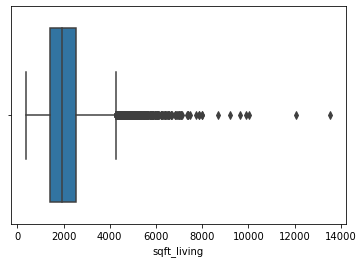

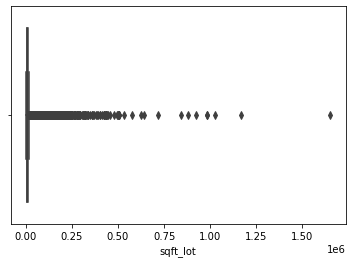

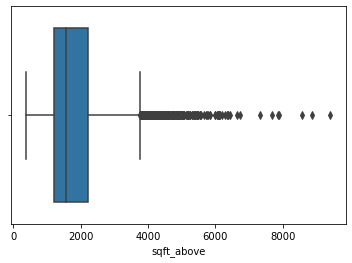

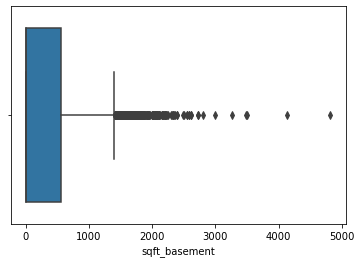

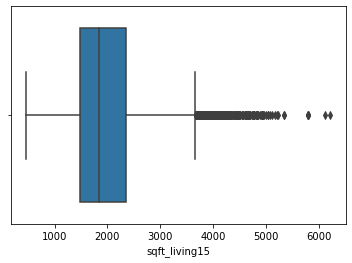

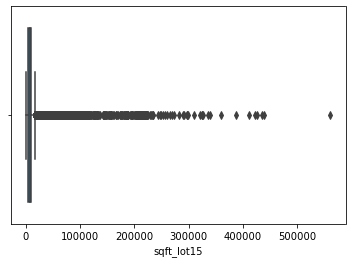

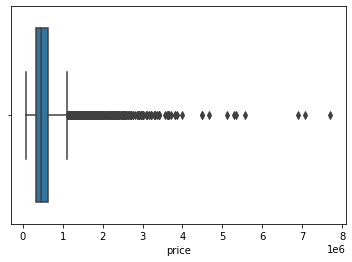

In [20]:
for column in df1.select_dtypes(np.number).columns:
    sns.boxplot(df1[column])
    plt.show()

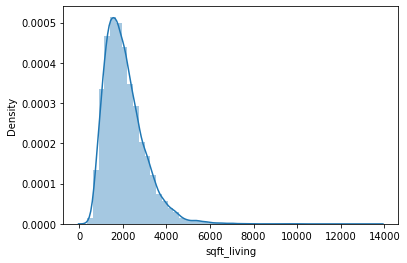

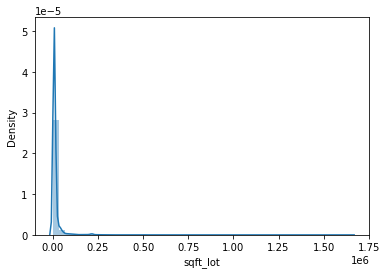

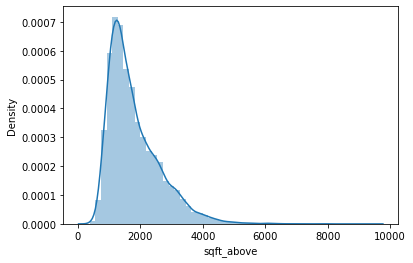

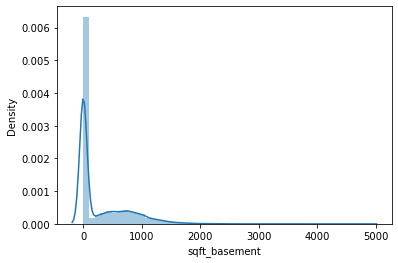

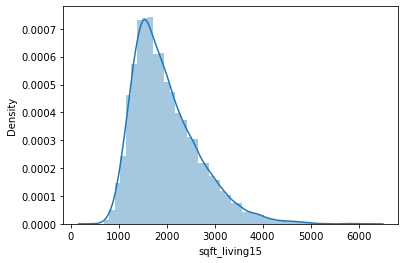

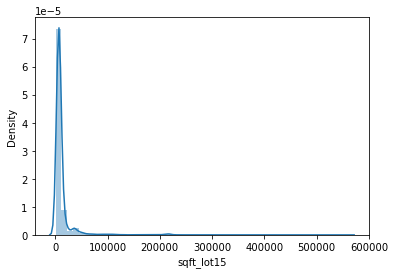

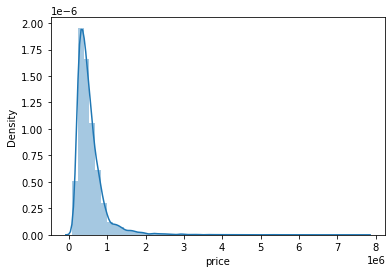

In [21]:
for column in df1.select_dtypes(np.number).columns:
    sns.distplot(df1[column])
    plt.show()

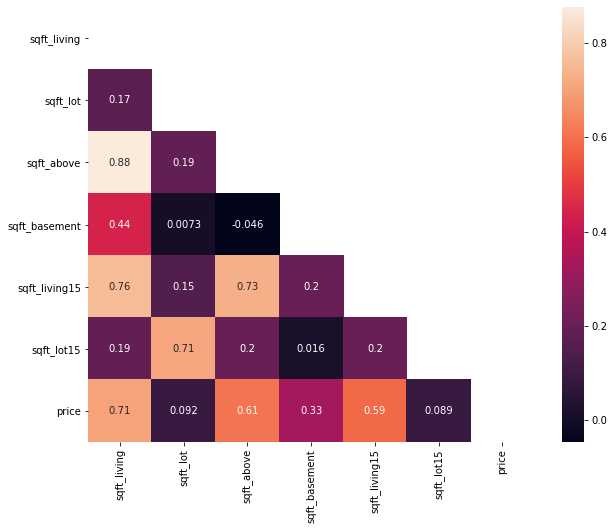

In [22]:
# check the correlations
mask = np.zeros_like(df1.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df1.corr(), mask=mask, annot=True)
plt.show()

# Dealing with outliers

In [23]:
for column in data_num:
    upper = np.percentile(data_num[column],75)
    lower = np.percentile(data_num[column],25)
    iqr = upper - lower
    upper_limit = upper + 1.5 * iqr
    lower_limit = lower - 1.5 * iqr
    clean_data_num = data_num[(data_num[column]>lower_limit) & (data_num[column]<upper_limit)]

# Feature scaling

In [24]:
#log boxcox. At first this gave me a R2 of 0,002 because it applied the log to Year, so it made it much more tied
#So I turned the yr_built and yr_renovated into objects
def boxcox_transform(clean_data_num):
    numeric_cols = clean_data_num.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        clean_data_num[column] = np.where(clean_data_num[column]<=0, np.NAN, clean_data_num[column])
        clean_data_num[column] = clean_data_num[column].fillna(clean_data_num[column].mean())
        transformed_data, ci = stats.boxcox(clean_data_num[column])
        clean_data_num[column] = transformed_data
        _ci[column] = ci
    return clean_data_num, _ci

In [25]:
clean_data_num, _ci = boxcox_transform(clean_data_num)

In [26]:
#adding clean numericals & categoricals
table = data_cat.merge(clean_data_num, right_index=True, left_index=True)
table

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zip_code,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,2,1.5,2,0,0,3,9,2007,0,98144,16.113291,3.969701,3.931261,163.031231,4.577087,3.873077,46.535772
1,3,2.75,2,0,0,3,8,1960,2012,98040,17.891305,4.386643,4.143476,200.247817,4.686361,4.222698,52.096843
2,2,1,1,0,0,3,7,1952,1990,98125,14.736630,4.330256,3.946139,200.247817,4.496132,4.210501,42.615769
3,3,1,1.5,0,0,4,7,1916,0,98107,15.696314,4.295466,4.012363,200.247817,4.684908,4.107641,49.995764
4,2,1,1,0,0,5,6,1942,0,98126,12.820801,4.311072,3.793251,200.247817,4.263353,4.154576,42.062963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,2,1.75,1,0,0,3,8,1962,1980,98027,16.567116,4.332465,3.953234,185.973599,4.655830,4.173892,46.134695
17272,3,2.25,3,0,0,3,8,2008,0,98103,14.899929,3.921569,3.957846,200.247817,4.455556,3.803767,45.681630
17273,6,1.75,2.5,0,0,4,9,1908,0,98122,18.637095,4.252846,4.171253,56.878654,4.644347,4.101877,50.549512
17274,3,1,1,0,0,3,7,1951,0,98115,13.900803,4.261221,3.883141,200.247817,4.546278,4.143336,47.171367


# Dummifying

In [27]:
df2 = df1.copy()
df2 = pd.get_dummies(table, drop_first=True)
df2

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price,bedrooms_2,bedrooms_3,bedrooms_4,...,zip_code_98146,zip_code_98148,zip_code_98155,zip_code_98166,zip_code_98168,zip_code_98177,zip_code_98178,zip_code_98188,zip_code_98198,zip_code_98199
0,16.113291,3.969701,3.931261,163.031231,4.577087,3.873077,46.535772,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17.891305,4.386643,4.143476,200.247817,4.686361,4.222698,52.096843,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,14.736630,4.330256,3.946139,200.247817,4.496132,4.210501,42.615769,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15.696314,4.295466,4.012363,200.247817,4.684908,4.107641,49.995764,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12.820801,4.311072,3.793251,200.247817,4.263353,4.154576,42.062963,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,16.567116,4.332465,3.953234,185.973599,4.655830,4.173892,46.134695,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17272,14.899929,3.921569,3.957846,200.247817,4.455556,3.803767,45.681630,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17273,18.637095,4.252846,4.171253,56.878654,4.644347,4.101877,50.549512,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17274,13.900803,4.261221,3.883141,200.247817,4.546278,4.143336,47.171367,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# ML model - LR

In [28]:
#splitting our data
X = df2.drop(['price'], axis=1)
y = df2['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
df2

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price,bedrooms_2,bedrooms_3,bedrooms_4,...,zip_code_98146,zip_code_98148,zip_code_98155,zip_code_98166,zip_code_98168,zip_code_98177,zip_code_98178,zip_code_98188,zip_code_98198,zip_code_98199
0,16.113291,3.969701,3.931261,163.031231,4.577087,3.873077,46.535772,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17.891305,4.386643,4.143476,200.247817,4.686361,4.222698,52.096843,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,14.736630,4.330256,3.946139,200.247817,4.496132,4.210501,42.615769,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15.696314,4.295466,4.012363,200.247817,4.684908,4.107641,49.995764,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12.820801,4.311072,3.793251,200.247817,4.263353,4.154576,42.062963,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17271,16.567116,4.332465,3.953234,185.973599,4.655830,4.173892,46.134695,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17272,14.899929,3.921569,3.957846,200.247817,4.455556,3.803767,45.681630,0,1,0,...,0,0,0,0,0,0,0,0,0,0
17273,18.637095,4.252846,4.171253,56.878654,4.644347,4.101877,50.549512,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17274,13.900803,4.261221,3.883141,200.247817,4.546278,4.143336,47.171367,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [31]:
predictions = model.predict(X_test)

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [33]:
print('The R2_score is',r2_score(y_test, predictions))
print ('The mean_absolute_error is', mean_absolute_error(y_test, predictions))
print('The mean_squared error is', mean_squared_error(y_test, predictions, squared=False))

The R2_score is 0.8622303809123699
The mean_absolute_error is 0.9959140971992483
The mean_squared error is 1.3602685533372791


<AxesSubplot:ylabel='price'>

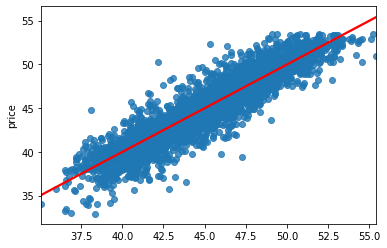

In [34]:
sns.regplot(predictions, y_test, line_kws={'color': 'red'})

In [35]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [36]:
knn.score(X_test, y_test)

0.5010252862422425